In [9]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# from tensorflow.image import resize
from skimage.transform import resize
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
# early stopping
from tensorflow.keras.callbacks import EarlyStopping



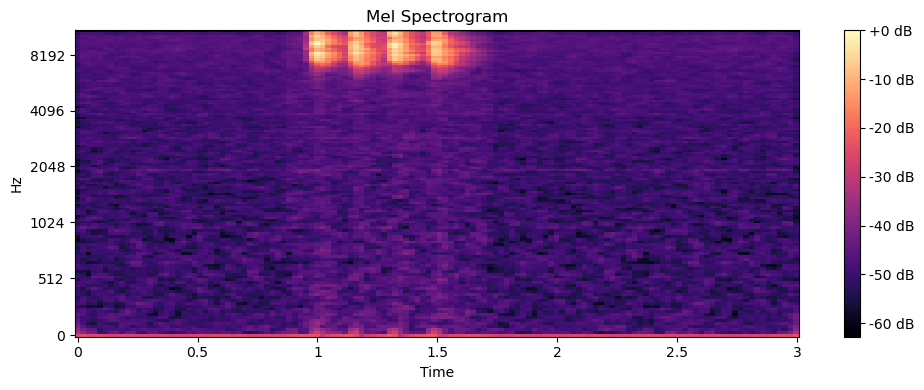

In [5]:
# Preprocessing code and spectrum


In [10]:
# Config
# Hyperparameters
data_dir = 'mel_spectrograms'
csv_path = 'taxonomy.csv'
target_shape = (128, 128)

# Loading metadata
metadata = pd.read_csv(csv_path)

# Encode class_name to numerical label
le = LabelEncoder()
metadata['label'] = le.fit_transform(metadata['class_name'])

# Map primary_label -> label
label_mapping = dict(zip(metadata['primary_label'].astype(str), metadata['label']))

# Define the 4 groups
groups = [
    {
        'name': 'Group 1: chirp + denoised',
        'file_types': ['_chirp.npy', '_denoised.npy']
    },
    {
        'name': 'Group 2: chirp + denoised_hpss',
        'file_types': ['_chirp.npy', '_denoised_hpss.npy']
    },
    {
        'name': 'Group 3: chirp + denoised_median_filter',
        'file_types': ['_chirp.npy', '_denoised_median_filter.npy']
    },
    {
        'name': 'Group 4: chirp + denoised_spectral',
        'file_types': ['_chirp.npy', '_denoised_spectral.npy']
    }
]

# Lists to store results
history_list = []
model_list = []
evaluation_results = []

In [11]:

# Evaluation function
def evaluate_model(model, history, X_test, y_test, le, group_name=None):
    # 1. Plot train and validate accuracy / loss curve
    plt.figure(figsize=(12, 5))
    
    title_suffix = f" - {group_name}" if group_name else ""

    # Accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Training and Validation Accuracy{title_suffix}')

    # Loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Validation Loss{title_suffix}')

    plt.tight_layout()
    plt.show()

    # 2. Model predict for report
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # 3. Output classification report
    print(f"\nClassification Report{title_suffix}:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    # 4. Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    plt.figure(figsize=(10, 8))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix{title_suffix}")
    plt.show()

    # 5. ROC Curve (multi-classification one-vs-rest)
    y_test_bin = y_test  # one-hot style

    plt.figure(figsize=(8, 6))

    for i, class_name in enumerate(le.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-class ROC Curve (One-vs-Rest){title_suffix}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Return metrics for comparison
    return {
        'y_pred': y_pred,
        'y_true': y_true,
        'y_pred_probs': y_pred_probs,
        'accuracy': history.history['val_accuracy'][-1]
    }

In [12]:
# Function to load all chirp files for testing
def load_test_data(data_dir, label_mapping, target_shape=(128, 128)):
    test_data = []
    test_labels = []
    test_files = []
    
    for folder_name in os.listdir(data_dir):
        if folder_name in label_mapping:
            folder_path = os.path.join(data_dir, folder_name)
            for filename in os.listdir(folder_path):
                if '_chirp.npy' in filename:
                    file_path = os.path.join(folder_path, filename)
                    spectrogram = np.load(file_path)
                    spectrogram = resize(spectrogram, target_shape, mode='reflect', anti_aliasing=True)
                    spectrogram = np.expand_dims(spectrogram, axis=-1)
                    test_data.append(spectrogram)
                    test_labels.append(label_mapping[folder_name])
                    test_files.append(file_path)
    
    return np.array(test_data), np.array(test_labels), test_files


# Function to load training data for each group
def load_train_data(data_dir, label_mapping, file_types, target_shape=(128, 128)):
    train_data = []
    train_labels = []
    
    for folder_name in os.listdir(data_dir):
        if folder_name in label_mapping:
            folder_path = os.path.join(data_dir, folder_name)
            for filename in os.listdir(folder_path):
                for file_type in file_types:
                    if file_type in filename:
                        file_path = os.path.join(folder_path, filename)
                        spectrogram = np.load(file_path)
                        spectrogram = resize(spectrogram, target_shape, mode='reflect', anti_aliasing=True)
                        spectrogram = np.expand_dims(spectrogram, axis=-1)
                        train_data.append(spectrogram)
                        train_labels.append(label_mapping[folder_name])
    
    return np.array(train_data), np.array(train_labels)

In [13]:
# Function to create model
def create_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(input_layer, output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Training and Evaluating Group 1: chirp + denoised
Training with 2059 samples, testing with 1029 samples
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.4332 - loss: 1.4354 - val_accuracy: 0.5666 - val_loss: 1.0735
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.5714 - loss: 1.0633 - val_accuracy: 0.6025 - val_loss: 0.9558
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.6100 - loss: 0.9520 - val_accuracy: 0.6569 - val_loss: 0.8231
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.6567 - loss: 0.8496 - val_accuracy: 0.6910 - val_loss: 0.7798
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.6946 - loss: 0.7683 - val_accuracy: 0.6948 - val_loss: 0.6882
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.7499 - loss: 0.6566 - val_accuracy: 0.7687 - val_loss: 0.5906
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.7930 - loss: 0.5891 - val_accuracy: 0.7969 - val_loss: 0.5131


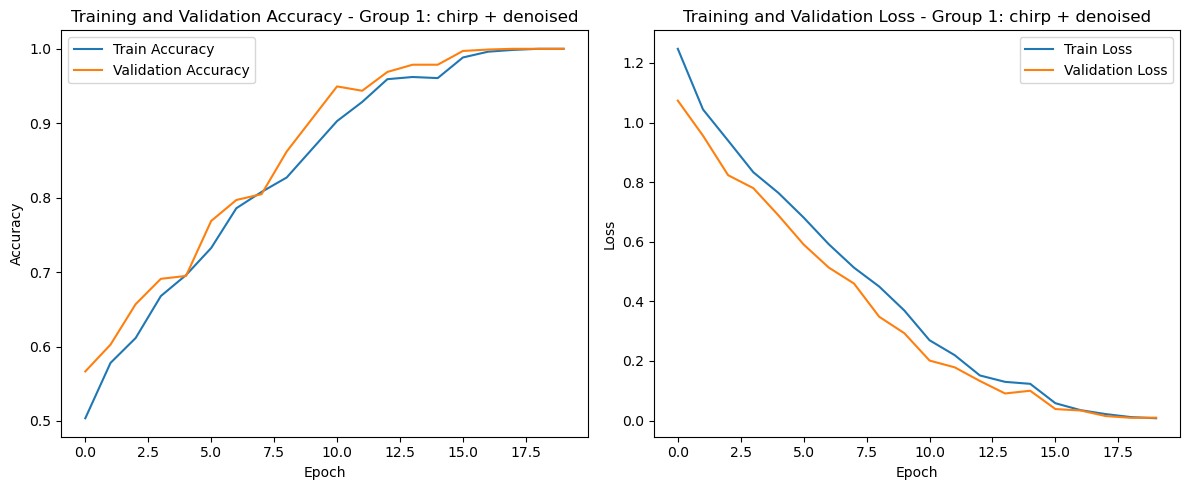

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

Classification Report - Group 1: chirp + denoised:
              precision    recall  f1-score   support

    Amphibia       1.00      1.00      1.00       583
        Aves       1.00      1.00      1.00       113
     Insecta       1.00      1.00      1.00       155
    Mammalia       1.00      1.00      1.00       178

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029



<Figure size 1000x800 with 0 Axes>

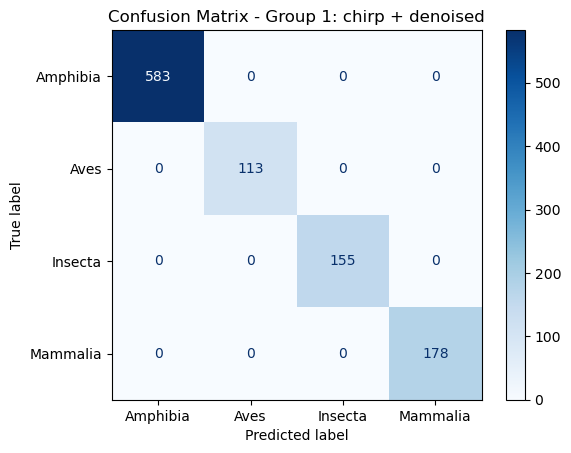

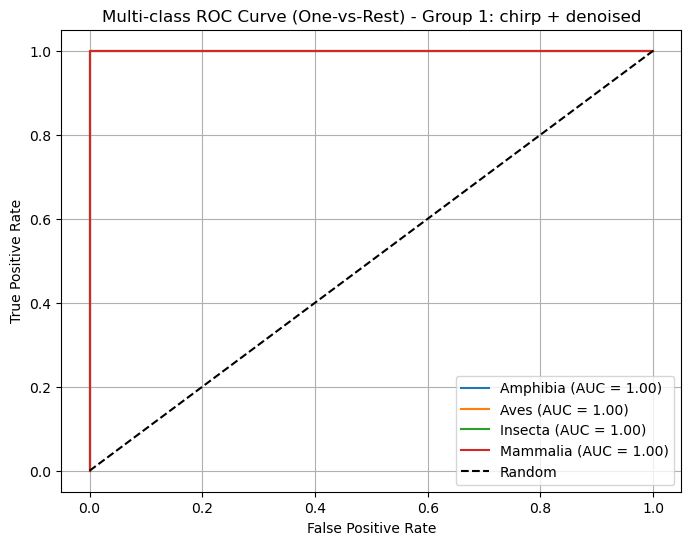


Training and Evaluating Group 2: chirp + denoised_hpss
Training with 2057 samples, testing with 1029 samples
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.5165 - loss: 1.1683 - val_accuracy: 0.6307 - val_loss: 0.9027
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.6643 - loss: 0.8189 - val_accuracy: 0.6900 - val_loss: 0.6897
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.7305 - loss: 0.6599 - val_accuracy: 0.7454 - val_loss: 0.5803
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.7854 - loss: 0.5521 - val_accuracy: 0.8484 - val_loss: 0.4403
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.8662 - loss: 0.4015 - val_accuracy: 0.8902 - val_loss: 0.3020
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9096 - loss: 0.2754 - val_accuracy: 0.9466 - val_loss: 0.1736
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9442 - loss: 0.1724 - val_accuracy: 0.9757 - val_loss: 0

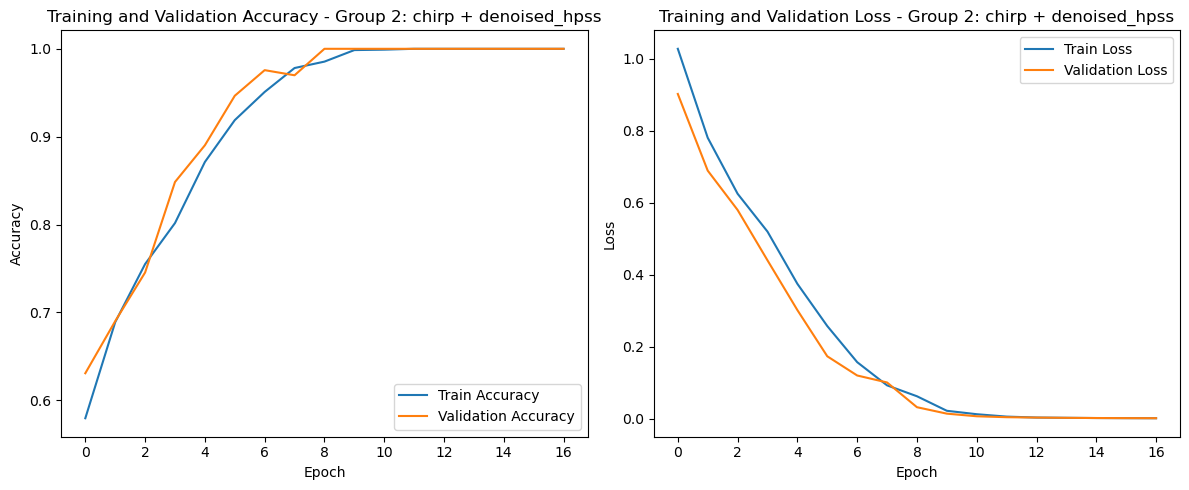

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Classification Report - Group 2: chirp + denoised_hpss:
              precision    recall  f1-score   support

    Amphibia       1.00      1.00      1.00       583
        Aves       1.00      1.00      1.00       113
     Insecta       1.00      1.00      1.00       155
    Mammalia       1.00      1.00      1.00       178

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029



<Figure size 1000x800 with 0 Axes>

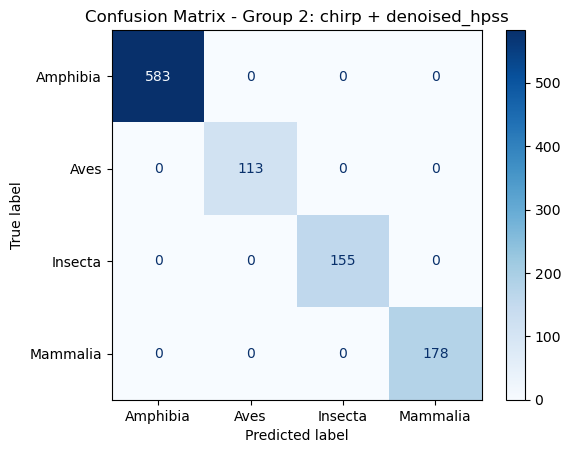

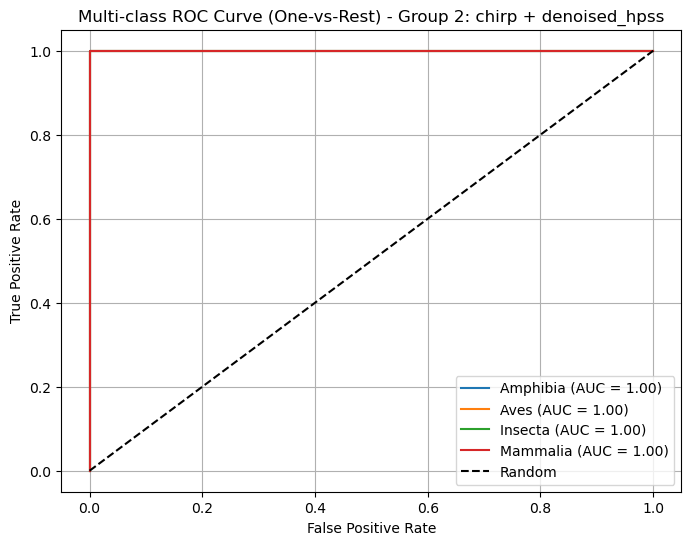


Training and Evaluating Group 3: chirp + denoised_median_filter
Training with 2057 samples, testing with 1029 samples
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.5279 - loss: 1.2672 - val_accuracy: 0.6132 - val_loss: 0.9351
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.6362 - loss: 0.8800 - val_accuracy: 0.7230 - val_loss: 0.6946
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.7369 - loss: 0.6657 - val_accuracy: 0.8017 - val_loss: 0.5073
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.8327 - loss: 0.4913 - val_accuracy: 0.8513 - val_loss: 0.3894
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.8817 - loss: 0.3465 - val_accuracy: 0.9397 - val_loss: 0.1972
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.9352 - loss: 0.2037 - val_accuracy: 0.9621 - val_loss: 0.1479
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9666 - loss: 0.1254 - val_accuracy: 0.9806 - 

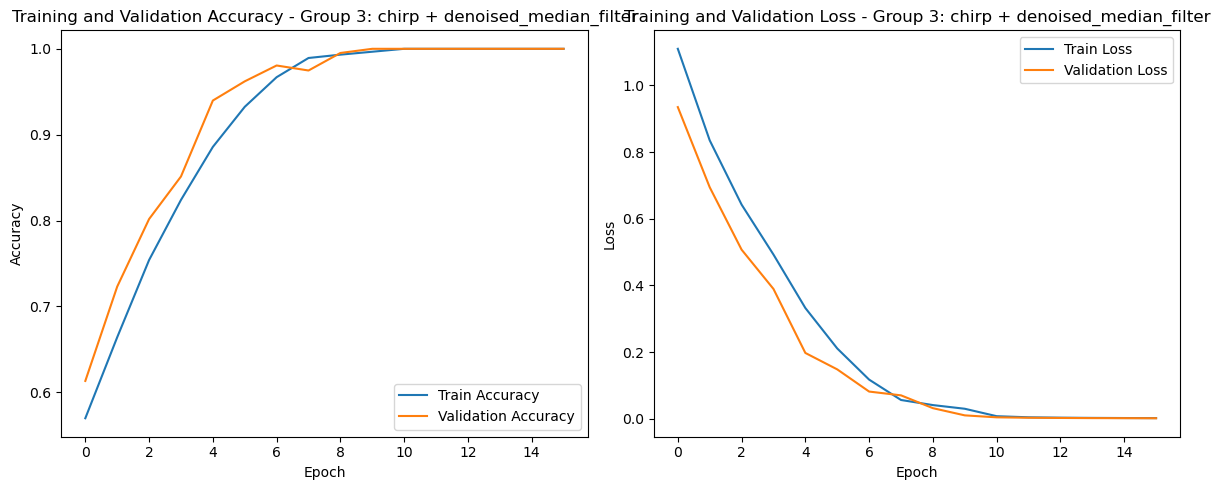

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

Classification Report - Group 3: chirp + denoised_median_filter:
              precision    recall  f1-score   support

    Amphibia       1.00      1.00      1.00       583
        Aves       1.00      1.00      1.00       113
     Insecta       1.00      1.00      1.00       155
    Mammalia       1.00      1.00      1.00       178

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029



<Figure size 1000x800 with 0 Axes>

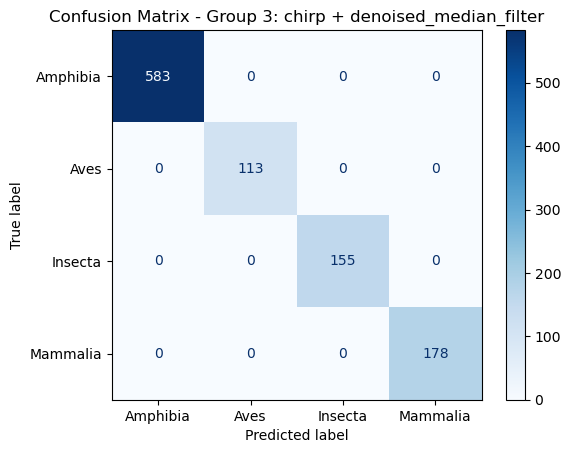

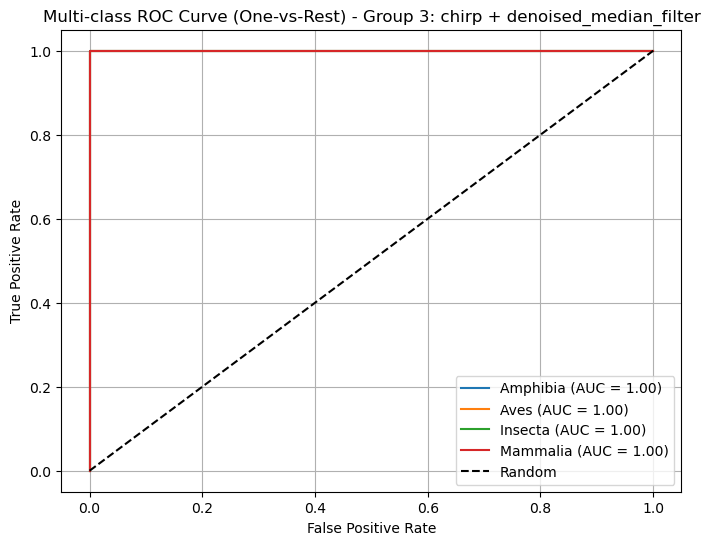


Training and Evaluating Group 4: chirp + denoised_spectral
Training with 2057 samples, testing with 1029 samples
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.5147 - loss: 1.3646 - val_accuracy: 0.6161 - val_loss: 0.9598
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.6154 - loss: 0.9557 - val_accuracy: 0.6433 - val_loss: 0.8110
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.6702 - loss: 0.8019 - val_accuracy: 0.7114 - val_loss: 0.7041
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - accuracy: 0.7253 - loss: 0.7135 - val_accuracy: 0.7386 - val_loss: 0.6433
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step - accuracy: 0.7626 - loss: 0.6492 - val_accuracy: 0.8037 - val_loss: 0.5679
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - accuracy: 0.8140 - loss: 0.5177 - val_accuracy: 0.8173 - val_loss: 0.4748
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.8302 - loss: 0.4443 - val_accuracy: 0.8659 - 

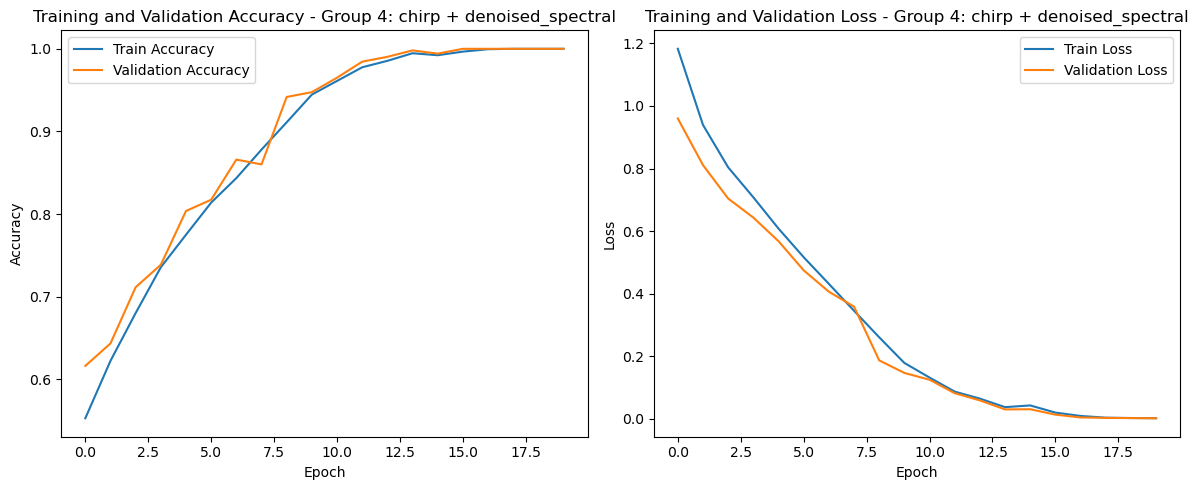

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

Classification Report - Group 4: chirp + denoised_spectral:
              precision    recall  f1-score   support

    Amphibia       1.00      1.00      1.00       583
        Aves       1.00      1.00      1.00       113
     Insecta       1.00      1.00      1.00       155
    Mammalia       1.00      1.00      1.00       178

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029



<Figure size 1000x800 with 0 Axes>

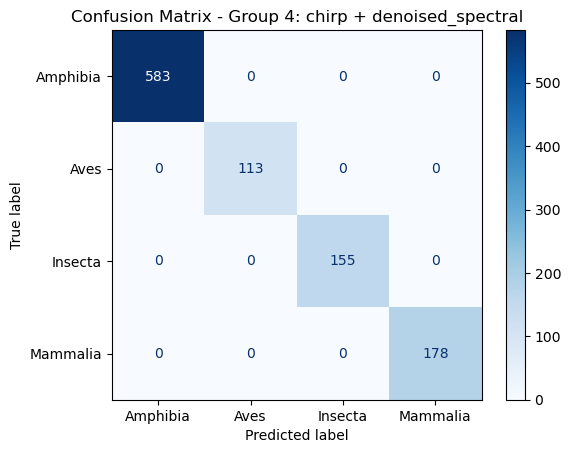

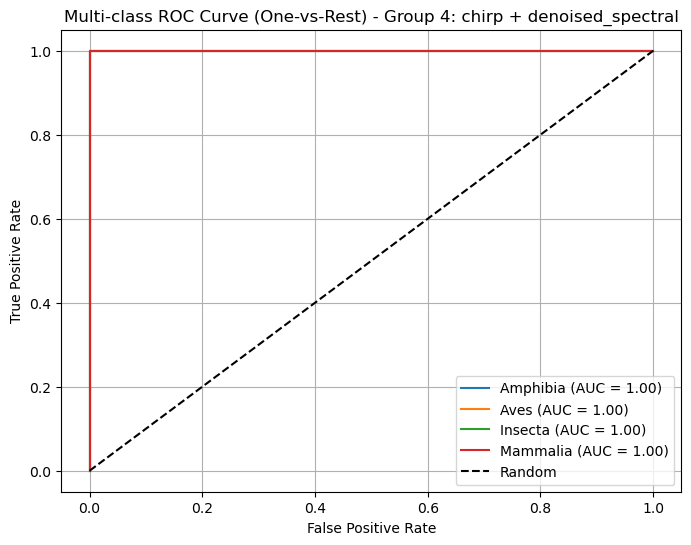

In [14]:
# Train models against 4 groups and evulate them

# Adding eraly stopping
# Create early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=2,              # Number of epochs with no improvement after which training will stop
    min_delta=0.001,         # Minimum change to qualify as an improvement
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored metric
    verbose=1                # Print messages
)

# Load test data (all chirp files)
X_test, y_test_raw, test_files = load_test_data(data_dir, label_mapping, target_shape)
y_test = to_categorical(y_test_raw, num_classes=len(le.classes_))

# Train and evaluate models for each group
for group in groups:
    print(f"\n{'='*80}")
    print(f"Training and Evaluating {group['name']}")
    print(f"{'='*80}")
    
    # Load training data for this group
    X_train, y_train_raw = load_train_data(data_dir, label_mapping, group['file_types'], target_shape)
    y_train = to_categorical(y_train_raw, num_classes=len(le.classes_))
    
    # Create and compile model
    model = create_model(X_train[0].shape, len(le.classes_))
    
    # # Train the model
    # print(f"Training with {len(X_train)} samples, testing with {len(X_test)} samples")
    # history = model.fit(
    #     X_train, y_train,
    #     validation_data=(X_test, y_test),
    #     epochs=20,
    #     batch_size=32,
    #     verbose=1
    # )
    # Train the model with early stopping
    print(f"Training with {len(X_train)} samples, testing with {len(X_test)} samples")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping]  # Add early stopping callback
    )
    
    # Store model and history
    history_list.append(history)
    model_list.append(model)
    
    # Evaluate the model
    print(f"\nEvaluating {group['name']}...")
    eval_result = evaluate_model(model, history, X_test, y_test, le, group['name'])
    evaluation_results.append(eval_result)



SUMMARY: MODEL PERFORMANCE COMPARISON

Accuracy Comparison:
Group                          | Final Validation Accuracy
------------------------------------------------------------
Group 1: chirp + denoised      | 1.000000
Group 2: chirp + denoised_hpss | 1.000000
Group 3: chirp + denoised_median_filter | 1.000000
Group 4: chirp + denoised_spectral | 1.000000


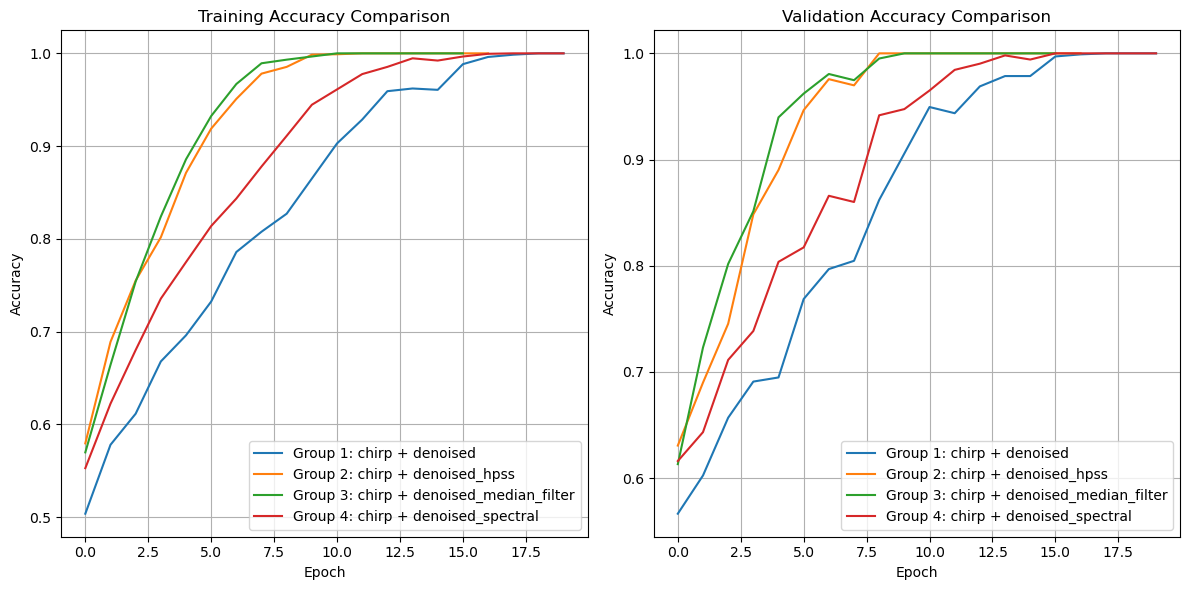


Training Duration:
Group                          | Epochs Trained  | Early Stopped  
----------------------------------------------------------------------
Group 1: chirp + denoised      |              20 | Yes            
Group 2: chirp + denoised_hpss |              17 | Yes            
Group 3: chirp + denoised_median_filter |              16 | Yes            
Group 4: chirp + denoised_spectral |              20 | Yes            

Class-wise Accuracy Comparison:
Class                |  1: chirp + denoised | hirp + denoised_hpss | noised_median_filter |  + denoised_spectral
----------------------------------------------------------------------------------------------------------------
Amphibia             | 1.0000               | 1.0000               | 1.0000               | 1.0000              
Aves                 | 1.0000               | 1.0000               | 1.0000               | 1.0000              
Insecta              | 1.0000               | 1.0000               | 1.0000 

In [15]:
# Final comparison of all models
print("\n" + "="*80)
print("SUMMARY: MODEL PERFORMANCE COMPARISON")
print("="*80)

# Accuracy comparison table
print("\nAccuracy Comparison:")
print(f"{'Group':30} | {'Final Validation Accuracy':25}")
print("-" * 60)
for i, group in enumerate(groups):
    print(f"{group['name']:30} | {evaluation_results[i]['accuracy']:.6f}")

# Plot accuracy comparison across all models
plt.figure(figsize=(12, 6))

# Training accuracy
plt.subplot(1, 2, 1)
for i, history in enumerate(history_list):
    plt.plot(history.history['accuracy'], label=f"{groups[i]['name']}")
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Validation accuracy
plt.subplot(1, 2, 2)
for i, history in enumerate(history_list):
    plt.plot(history.history['val_accuracy'], label=f"{groups[i]['name']}")
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

#adding stop epoch
# Print stopping epoch for each model
print("\nTraining Duration:")
print(f"{'Group':30} | {'Epochs Trained':15} | {'Early Stopped':15}")
print("-" * 70)
for i, history in enumerate(history_list):
    epochs_trained = len(history.history['loss'])
    early_stopped = epochs_trained < 50  # If we trained fewer than max epochs
    print(f"{groups[i]['name']:30} | {epochs_trained:15d} | {'Yes' if early_stopped else 'No':15}")

# Class-wise accuracy comparison
print("\nClass-wise Accuracy Comparison:")
class_accuracies = {}

# Calculate per-class accuracy for each model
for i, result in enumerate(evaluation_results):
    y_true = result['y_true']
    y_pred = result['y_pred']
    
    for class_idx, class_name in enumerate(le.classes_):
        if class_name not in class_accuracies:
            class_accuracies[class_name] = []
            
        # Get indices for this class
        class_indices = np.where(y_true == class_idx)[0]
        if len(class_indices) > 0:
            correct = np.sum(y_pred[class_indices] == class_idx)
            accuracy = correct / len(class_indices)
        else:
            accuracy = float('nan')
            
        class_accuracies[class_name].append(accuracy)

# Print class-wise accuracies
print(f"{'Class':20} | " + " | ".join([f"{group['name'][-20:]:20}" for group in groups]))
print("-" * (20 + 23 * len(groups)))

for class_name, accuracies in class_accuracies.items():
    acc_strings = [f"{acc:.4f}" if not np.isnan(acc) else "N/A" for acc in accuracies]
    print(f"{class_name:20} | " + " | ".join([f"{acc_str:20}" for acc_str in acc_strings]))

# Find where models disagree
print("\nAnalyzing samples where models disagree...")
disagreements = []

for i in range(len(X_test)):
    predictions = [evaluation_results[j]['y_pred'][i] for j in range(len(groups))]
    if len(set(predictions)) > 1:  # Models have different predictions
        disagreements.append({
            'index': i,
            'file': test_files[i],
            'true_class': le.classes_[evaluation_results[0]['y_true'][i]],
            'predictions': [le.classes_[pred] for pred in predictions]
        })

print(f"\nFound {len(disagreements)} samples (out of {len(X_test)}) where models disagree")

if disagreements:
    print("\nSample disagreements (first 5):")
    for i, d in enumerate(disagreements[:5]):
        print(f"Sample {i+1}: {d['file']}")
        print(f"  True class: {d['true_class']}")
        for j, group in enumerate(groups):
            print(f"  {group['name']}: predicted '{d['predictions'][j]}'")
        print()

In [ ]:
# Save Model
model.save('animal_classifier.h5')